In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Loading dataset
weekly_sales = pd.read_csv("D:\m5_demand_forecasting_project\outputs\weekly_sales.csv")

#Top 3 by total sales
top3_skus = (weekly_sales.groupby("item_id")["sales"].sum().sort_values(ascending=False).head(3).index.tolist())

# Preview
print("Top 3 SKUs:", top3_skus)

Top 3 SKUs: ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252']


---
**Key Findings:**

Loading the dataset, structured for rolling windows, lag analysis with sorted for time series consistency and taking top 3 high-volume SKUs for initiating Time Series and Machine Learning Modelling.

---

In [2]:
# Augmented Dickey-Fuller (ADF) test for chechking Non-Stationarity
def run_adf_test(df, skus):
    results = []

    for sku in skus:
        # Aggregate weekly sales across all stores
        ts = (
            df[df['item_id'] == sku]
            .groupby('year_week')['sales']
            .sum()
            .sort_index()
        )

        # Run ADF test
        adf_result = adfuller(ts)

        results.append({
            'item_id': sku,
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'stationary': 'Yes' if adf_result[1] < 0.05 else 'No'
        })

    return pd.DataFrame(results)

# Running ADF
adf_results = run_adf_test(weekly_sales, top3_skus)
print(adf_results)

       item_id  adf_statistic   p_value stationary
0  FOODS_3_090      -5.342516  0.000004        Yes
1  FOODS_3_586      -2.373669  0.149306         No
2  FOODS_3_252      -4.557213  0.000155        Yes


---
**Key Findings:**

Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary. ADF Test on original series leads to two SKUs are ststionary and one SKU was non-stationary (p-value > 0.05), indicating trends or seasonality.

---

In [3]:
# ARIMA forecast modelling
def compute_arima_metrics(df, skus, forecast_horizon=4, arima_order=(1,1,1)):
    results = []

    for sku in skus:
        sku_df = df[df['item_id'] == sku]

        # Top-selling store
        top_store = (
            sku_df.groupby('store_id')['sales']
            .sum()
            .idxmax()
        )

        # Weekly sales across all stores
        ts = (
            sku_df.groupby('year_week')['sales']
            .sum()
            .sort_index()
            .values
        )

        if len(ts) <= forecast_horizon:
            continue

        history = ts[:-forecast_horizon]
        actual  = ts[-forecast_horizon:]

        # Fit ARIMA and forecast
        try:
            model = ARIMA(history, order=arima_order).fit()
            forecast = model.forecast(steps=forecast_horizon)
        except:
            continue

        # Metrics
        mse   = mean_squared_error(actual, forecast)
        rmse  = np.sqrt(mse)
        smape = np.mean(
            2 * np.abs(forecast - actual) /
            (np.abs(actual) + np.abs(forecast))
        ) * 100

        # RMSSE scale
        diffs = np.diff(history)
        scale = np.mean(diffs**2) if len(diffs) > 0 else np.nan
        rmsse = np.sqrt(mse / scale) if scale and scale > 0 else np.nan

        results.append({
            'item_id':   sku,
            'store_id': top_store,
            'rmse':      rmse,
            'smape':     smape,
            'rmsse':     rmsse,
            'volume':    history.sum()
        })

    # Convert to DataFrame
    res = pd.DataFrame(results)

    # Compute weights and WRMSSE
    total_volume = res['volume'].sum()
    res['weight']  = res['volume'] / total_volume
    res['wrmsse']  = res['weight'] * res['rmsse']

    return res[['item_id', 'store_id', 'rmse', 'smape', 'rmsse', 'weight', 'wrmsse']]

# Run ARIMA forecasting
arima_results = compute_arima_metrics(weekly_sales, top3_skus, forecast_horizon=4)
print("Linear Regression:\n", arima_results)

Linear Regression:
        item_id store_id        rmse     smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3  304.418786  5.624490  0.209569  0.402402  0.084331
1  FOODS_3_586     TX_2  216.438918  5.857654  0.615086  0.370429  0.227846
2  FOODS_3_252     TX_2  126.492130  5.623377  0.509323  0.227169  0.115702


---
**Key Findings:** 
1. The ARIMA model captures linear autoregressive and moving average patterns, effectively modeling trend and seasonality when properly differenced and parameterized.
2. ARIMA forecasting provides a baseline that accounts for autocorrelation; compare its performance against ML models to assess the value of additional features and nonlinearity.
---

In [4]:
# First Order Differencing for exclude Non-stationarity in SKU
def check_stationarity(ts):
    result = adfuller(ts)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else " Non-stationary")

ts = (
    weekly_sales[weekly_sales['item_id'] == 'FOODS_3_586']
    .groupby('year_week')['sales']
    .sum()
    .sort_index()
    .values
)

# Checking Stationarity after first order differentiation
diff_ts = np.diff(ts, n=1)
check_stationarity(diff_ts)

ADF Statistic: -5.9287
p-value: 0.0000
Stationary


---
**Key Findings:**

After first differencing , the same SKU became stationary (p-value < 0.05), confirming that ARIMA with d=1 is appropriate.

---

In [5]:
# Linear, Ridge & lasso Regression modelling
def compute_regression_metrics(df, skus, model_type="linear", forecast_horizon=4, lags=4):
    results = []

    def get_model(model_type):
        if model_type == "linear":
            return LinearRegression()
        elif model_type == "ridge":
            return Ridge(alpha=1.0)
        elif model_type == "lasso":
            return Lasso(alpha=0.1)
        else:
            raise ValueError("Invalid model_type. Choose from 'linear', 'ridge', or 'lasso'.")

    for sku in skus:
        sku_df = df[df["item_id"] == sku]
        top_store = (
            sku_df.groupby("store_id")["sales"]
            .sum()
            .idxmax()
        )
        ts = (
            sku_df.groupby("year_week")["sales"]
            .sum()
            .sort_index()
            .values
        )
        if len(ts) <= forecast_horizon + lags:
            continue

        history = ts[:-forecast_horizon]
        actual  = ts[-forecast_horizon:]

        # Lagged features
        lagged = pd.DataFrame({"sales": history})
        for lag in range(1, lags + 1):
            lagged[f"lag_{lag}"] = lagged["sales"].shift(lag)
        lagged.dropna(inplace=True)

        X_train = lagged.drop("sales", axis=1)
        y_train = lagged["sales"]

        model = get_model(model_type)
        model.fit(X_train, y_train)

        # Recursive forecast
        last_row = X_train.iloc[-1:].copy()
        forecast = []

        for _ in range(forecast_horizon):
            pred = model.predict(last_row)[0]
            forecast.append(pred)

            last_row = last_row.shift(-1, axis=1)
            last_row.iloc[0, -1] = pred

        # Metrics
        mse   = mean_squared_error(actual, forecast)
        rmse  = np.sqrt(mse)
        smape = np.mean(
            2 * np.abs(np.array(forecast) - actual) /
            (np.abs(actual) + np.abs(forecast))
        ) * 100

        # RMSSE scale
        diffs = np.diff(history)
        scale = np.mean(diffs**2) if len(diffs) > 0 else np.nan
        rmsse = np.sqrt(mse / scale) if scale and scale > 0 else np.nan

        results.append({
            "item_id": sku,
            "store_id": top_store,
            "rmse": rmse,
            "smape": smape,
            "rmsse": rmsse,
            "volume": history.sum()
        })

    # Final DataFrame
    res = pd.DataFrame(results)
    total_volume = res["volume"].sum()
    res["weight"]  = res["volume"] / total_volume
    res["wrmsse"]  = res["weight"] * res["rmsse"]

    return res[["item_id", "store_id", "rmse", "smape", "rmsse", "weight", "wrmsse"]]

# Run Regression models
linear_results = compute_regression_metrics(weekly_sales, top3_skus, model_type="linear", forecast_horizon=4, lags=4)
ridge_results  = compute_regression_metrics(weekly_sales, top3_skus, model_type="ridge", forecast_horizon=4, lags=4)
lasso_results  = compute_regression_metrics(weekly_sales, top3_skus, model_type="lasso", forecast_horizon=4, lags=4)

print("Linear Regression:\n", linear_results)
print("Ridge Regression:\n", ridge_results)
print("Lasso Regression:\n", lasso_results)

Linear Regression:
        item_id store_id        rmse     smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3   95.446299  2.089931  0.065707  0.402402  0.026441
1  FOODS_3_586     TX_2  133.399456  4.104664  0.379101  0.370429  0.140430
2  FOODS_3_252     TX_2  111.145655  4.913142  0.447530  0.227169  0.101665
Ridge Regression:
        item_id store_id        rmse     smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3   95.446299  2.089931  0.065707  0.402402  0.026441
1  FOODS_3_586     TX_2  133.399459  4.104664  0.379101  0.370429  0.140430
2  FOODS_3_252     TX_2  111.145652  4.913142  0.447530  0.227169  0.101665
Lasso Regression:
        item_id store_id        rmse     smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3   95.446299  2.089931  0.065707  0.402402  0.026441
1  FOODS_3_586     TX_2  133.399657  4.104669  0.379101  0.370429  0.140430
2  FOODS_3_252     TX_2  111.145611  4.913141  0.447530  0.227169  0.101665


---
**Key Findings**
1. Lag-based features capture temporal patterns effectively.
2. Recursive forecasting mimics real-world deployment.
3. Linear is fast and interpretable, Ridge handles multicollinearity and Lasso adds feature selection.
---

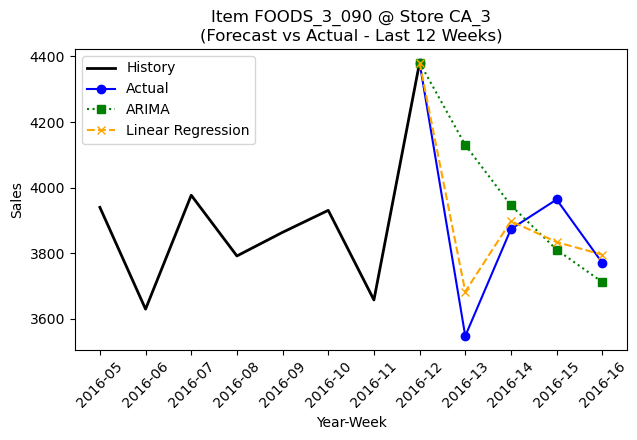

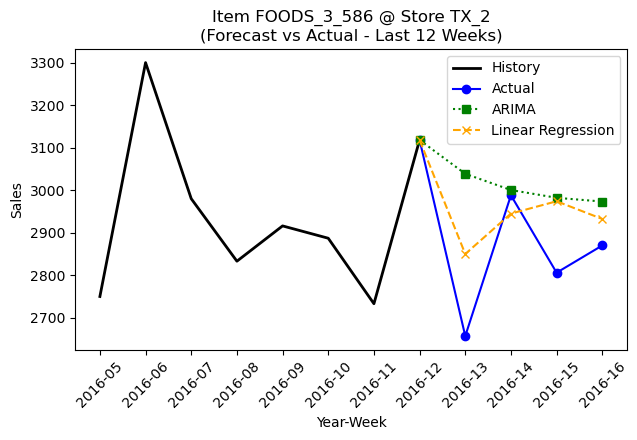

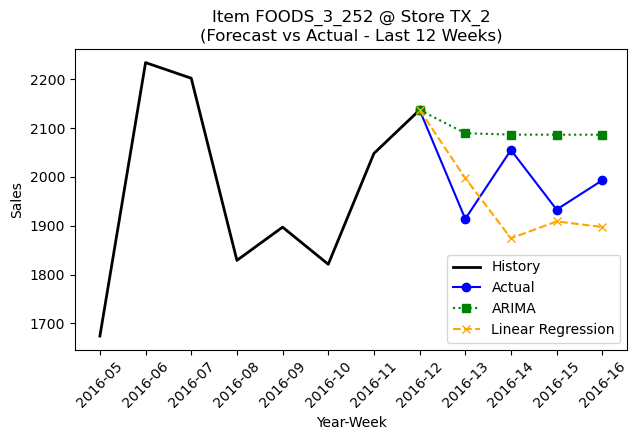

In [25]:
# Plotting Time Series vs M.L. vs Actual Forecasts
forecast_horizon = 4
context_window    = 12
arima_order       = (1, 1, 1)
lags              = 4

for sku in top3_skus:
    sku_df = weekly_sales[weekly_sales['item_id'] == sku]
    top_store = sku_df.groupby('store_id')['sales'].sum().idxmax()

    ts_series = (
        sku_df
        .groupby('year_week')['sales']
        .sum()
        .sort_index()
    )

    if len(ts_series) < forecast_horizon + lags:
        continue

    history = ts_series.iloc[:-forecast_horizon]
    actual  = ts_series.iloc[-forecast_horizon:]
    index_h = history.index
    index_f = actual.index

    # ARIMA Forecast 
    arima_model = ARIMA(history.values, order=arima_order).fit()
    arima_pred  = arima_model.forecast(steps=forecast_horizon)
    arima_series = pd.Series(arima_pred, index=index_f)

    # Linear Regression Forecast (lasso and ridge will give same reslts)
    df_lag = pd.DataFrame({'y': history.values}, index=index_h)
    for lag in range(1, lags + 1):
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    df_lag.dropna(inplace=True)

    X_train = df_lag.drop('y', axis=1)
    y_train = df_lag['y']

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    last_feats = X_train.iloc[-1:].copy()
    linreg_preds = []
    for _ in range(forecast_horizon):
        p = linreg.predict(last_feats)[0]
        linreg_preds.append(p)
        last_feats = last_feats.shift(-1, axis=1)
        last_feats.iloc[0, -1] = p

    linreg_series = pd.Series(linreg_preds, index=index_f)

    # Plotting
    last_12 = ts_series.iloc[-context_window:]
    last_8  = last_12.iloc[:-forecast_horizon]
    last_4  = last_12.iloc[-forecast_horizon:]

    plt.figure(figsize=(6.5, 4.5))

    # History
    plt.plot(last_8.index, last_8.values,
             label="History", color="black", linewidth=2)

    # Actual
    actual_connected = pd.Series(
        [last_8.values[-1]] + list(last_4.values),
        index=[last_8.index[-1]] + list(last_4.index)
    )
    plt.plot(actual_connected.index, actual_connected.values,
             label="Actual", color="blue", marker="o")

    # ARIMA forecast
    arima_full = pd.Series(
        [last_8.values[-1]] + list(arima_series.values),
        index=[last_8.index[-1]] + list(index_f)
    )
    plt.plot(arima_full.index, arima_full.values,
             label="ARIMA", color="green", linestyle=":", marker="s")

    # Linear Regression forecast
    linreg_full = pd.Series(
        [last_8.values[-1]] + list(linreg_series.values),
        index=[last_8.index[-1]] + list(index_f)
    )
    plt.plot(linreg_full.index, linreg_full.values,
             label="Linear Regression", color="orange", linestyle="--", marker="x")

    # Title and layout
    plt.title(f"Item {sku} @ Store {top_store}\n(Forecast vs Actual - Last {context_window} Weeks)")
    plt.xlabel("Year-Week")
    plt.ylabel("Sales")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

---
**Key Findings:** 
1. Shows last 12 weeks: 8 history + 4 forecast.
2. Forecasts are visually anchored to actuals for clarity.
3. ARIMA vs. regression comparison reveals easy to spot over/under-prediction and trend alignment.
---

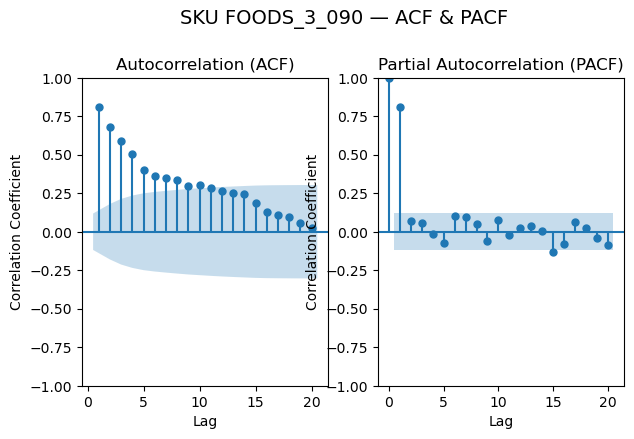

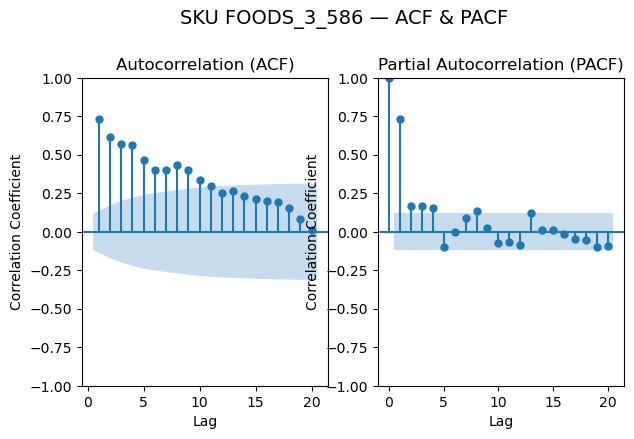

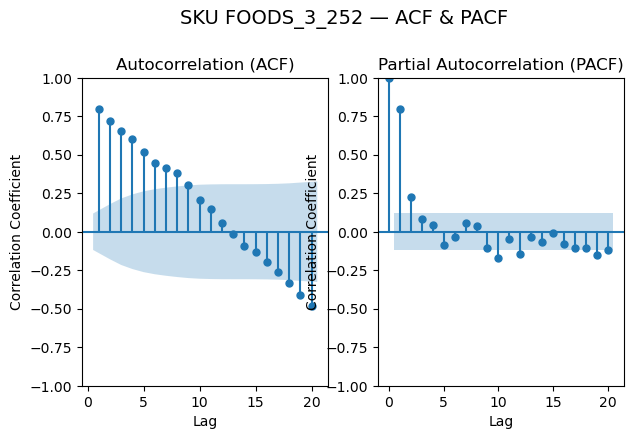

In [26]:
# Residual diagnosis
def plot_acf_pacf_for_skus(df, skus, lags=24, figsize=(12, 4)):

    for sku in skus:
        # 1) Subset & aggregate
        sku_ts = (
            df[df['item_id'] == sku]
              .groupby('year_week')['sales']
              .sum()
              .sort_index()
        )

        if len(sku_ts) < 2:
            print(f"Not enough data to plot ACF/PACF for SKU {sku}")
            continue

        # Build the figure
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(f"SKU {sku} — ACF & PACF", fontsize=14, y=1.05)

        # Plot ACF
        plot_acf(sku_ts, lags=lags, ax=axes[0], zero=False)
        axes[0].set_title("Autocorrelation (ACF)")
        axes[0].set_xlabel("Lag")
        axes[0].set_ylabel("Correlation Coefficient")

        # Plot PACF
        plot_pacf(sku_ts, lags=lags, ax=axes[1], method='ywmle')
        axes[1].set_title("Partial Autocorrelation (PACF)")
        axes[1].set_xlabel("Lag")
        axes[1].set_ylabel("Correlation Coefficient")

# Running ACF & PACF plots
plot_acf_pacf_for_skus(weekly_sales, top3_skus, lags=20, figsize=(7, 4))

---
**Key Findings:** 

1. At Lag 1, noticeable positive autocorrelation in both ACF and PACF but at Lag 4, ACF shows gradual decay and PACF near zero indicates minimal direct influence.
2. All three SKUs implies that the residuals are not white noise, which is a key assumption for a well-fitted ARIMA model.
---

In [8]:
# Merge ARIMA and Linear
combined = pd.merge(
    arima_results, linear_results,
    on=["item_id", "store_id"],
    suffixes=("_arima", "_linear")
)

# Merge with Lasso
combined = pd.merge(
    combined, lasso_results,
    on=["item_id", "store_id"],
    suffixes=("", "_lasso")
)

# Rename overlapping columns from lasso
for col in ["rmse", "smape", "rmsse", "weight", "wrmsse"]:
    if col in combined.columns:
        combined.rename(columns={col: f"{col}_lasso"}, inplace=True)

# Merge with Ridge
combined = pd.merge(
    combined, ridge_results,
    on=["item_id", "store_id"],
    suffixes=("", "_ridge")
)

# Rename overlapping columns from ridge
for col in ["rmse", "smape", "rmsse", "weight", "wrmsse"]:
    if col in combined.columns:
        combined.rename(columns={col: f"{col}_ridge"}, inplace=True)

# Saving the combine results to CSV
combined.to_csv("D:\\m5_demand_forecasting_project\\outputs\\ts_ml_forecast_results.csv", index=False)

---
**Notebook Summary:**

This notebook implements and compares ARIMA and Regression models, computing RMSE, sMAPE and WRMSSE metrics. ARIMA provides a solid time-series benchmark, while Regression captures additional feature-driven variations, offering the best overall accuracy.

---